<a href="https://colab.research.google.com/github/Nyillu/Algorithms_Big_Data_Zavadskaya/blob/main/homework_4_and_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimension reduction

In this notebook you can find two homework assignments: dimensionality reduction and clustering.

Dimension reduction was performed using:

- [ ] linear dimension reduction method: `PCA`
- [ ] non-linear dimension reduction method: `t-SNE` and `UMAP`

Clustering was performed using the `AgglomerativeClustering` and `DBSCAN`.

This code is made to be run locally within current repository. If you work in Google Colab, adjust the path to the `data_normalized.csv` file accordingly and install the libraries provided in the *requirements*.



# Requirements

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Big data/data_normalized.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19616 entries, 0 to 19615
Columns: 206 entries, smiles to TopoShapeIndex
dtypes: float64(205), object(1)
memory usage: 30.8+ MB


# Linear dimension reduction method: PCA

In [5]:
descriptors = df.drop(['smiles', 'gap'], axis = 1)

In [6]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(descriptors)

print('Original dimension:', descriptors.shape)
print('Reduced dimension:', X_reduced.shape)
print('Explained variance:', sum(pca.explained_variance_ratio_))

Original dimension: (19616, 204)
Reduced dimension: (19616, 74)
Explained variance: 0.9502699915336976


The number of components `n_components=0.95` means that explained variance is 95%. As a result, we get the number of PCs $=74$. The graph below actually shows that the value $74$ is optimal, because after it the explained variance almost does not increase

In [7]:
n_components = 74

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, n_components+1), y=np.cumsum(pca.explained_variance_ratio_), mode='lines+markers'))
fig.update_layout(title='Explained Variance by Number of Components',
                  xaxis_title='Number of Components',
                  yaxis_title='Explained Variance',
                  template='plotly_white')
fig.show()

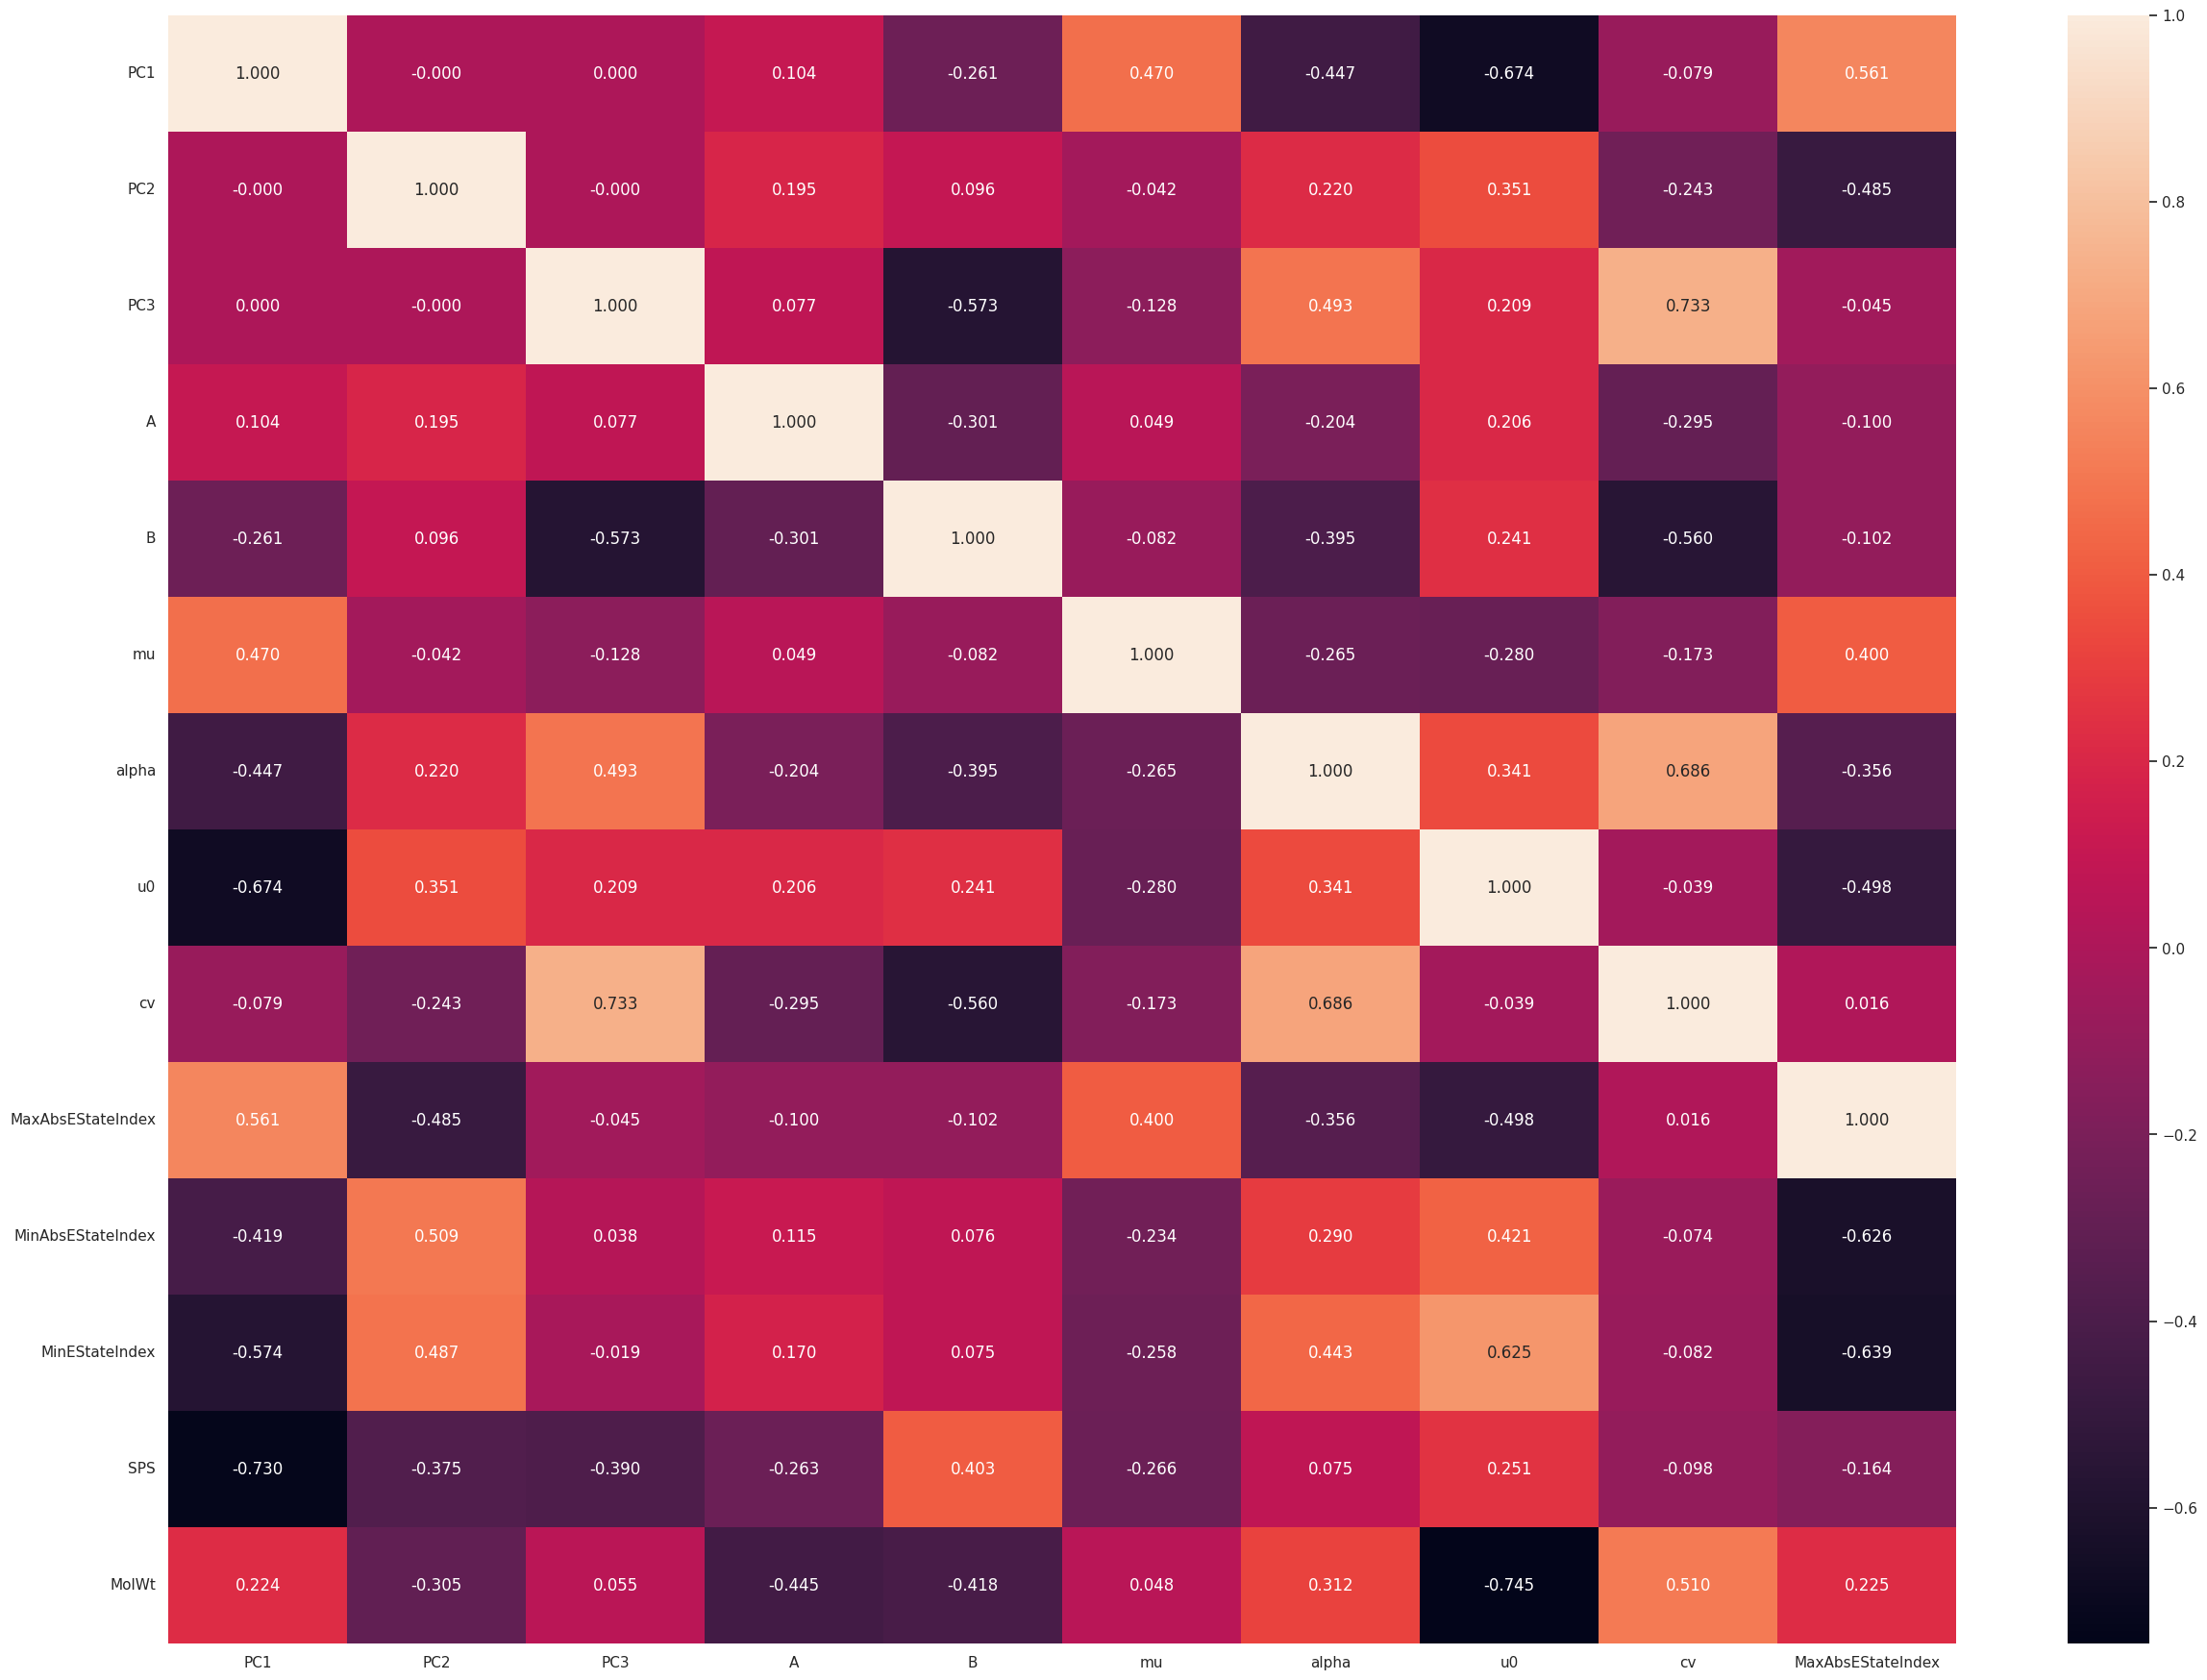

In [66]:
#Combine the original data and first three PCs
df_pc = pd.DataFrame(data = X_reduced, columns = [f'PC{i}' for i in range(1,75)])
df_col = pd.concat([df_pc[['PC1','PC2','PC3']],pd.DataFrame(descriptors, columns=descriptors.columns)], axis=1)
df_col

corMatrix = pd.DataFrame.corr(df_col)

# Selection of only the first 10 descriptors so that the matrix is representative
corMatrix_subset = corMatrix.iloc[:14, :10]

# results
sns.set(rc={'figure.figsize':(30,22)})
sns.heatmap(corMatrix_subset, annot=True, fmt='.3f')
plt.show()

We see that our PCs do not correlate with each other. Also it is clear that there is a strong correlation between PC1 with columns `'SPS'` and `'u0'`. This means that they made the greatest impact and perhaps PC1 is a linear combination of these features. Among other descriptors there may be additional features that correlate with our PCs.

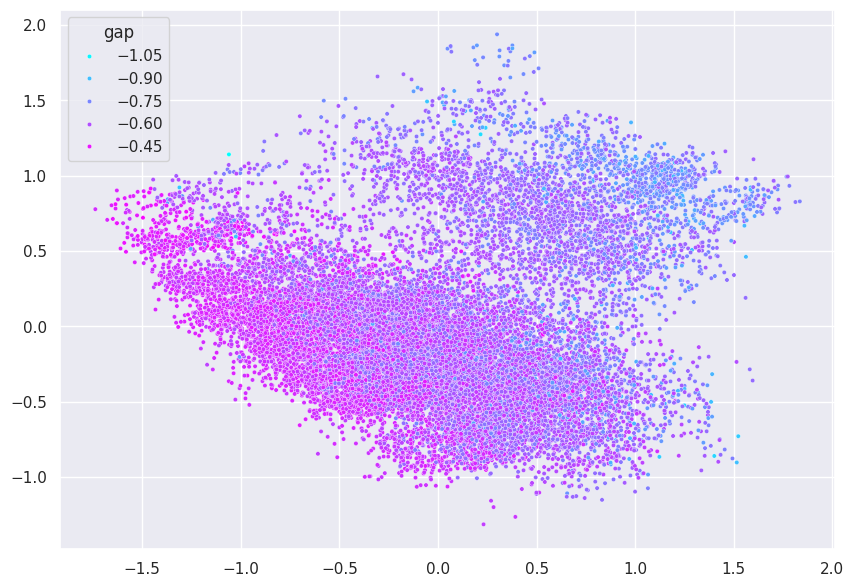

In [ ]:
# perform PCA and plot 2D-space coloured by gap
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(descriptors)
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df, x=reduced_X[:, 0], y=reduced_X[:, 1], hue=np.log10(df['gap']), s=10, palette='cool')
plt.show()

Although PCA is not the best method for our data, even with it we can see the separation of molecules by `gap` values

In [70]:
data_PCA = df[['smiles', 'gap']].merge(df_pc, how='inner', left_index=True, right_index=True)

In [73]:
data_PCA.to_csv('data_PCA.csv', index = False)

# Non-linear dimension reduction method: UMAP and  t-SNE

## UMAP

По результатаv UMAP показывает лучшее разделение молекул на отдельные кластеры, но при этом взаимосвязь кластера с величиной `gap` наблюдается не везде.

In [8]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 617.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.7 MB/s eta 0:00:00


In [9]:
import umap

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



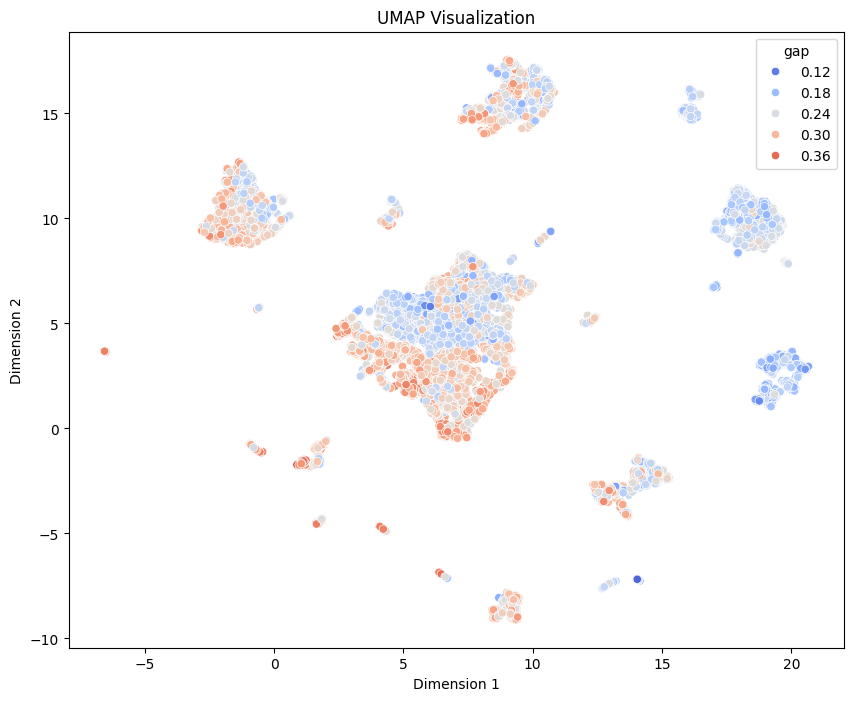

In [11]:
# Extracting descriptors and target variable
X = df.drop(['smiles', 'gap'], axis=1)  # Drop the 'smiles' and 'gap' columns
y = df['gap']

umap_model = umap.UMAP(n_components=2, random_state=2024)
X_umap = umap_model.fit_transform(X)

# Create a new DataFrame with the reduced dimensions and target variable
cols = [f'Dimension {i+1}' for i in range(X_umap.shape[1])]
df_umap = pd.DataFrame(data=X_umap, columns=cols)
df_umap['gap'] = y.values

# Visualizing the reduced dimensions using Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x=cols[0], y=cols[1] if len(cols) > 1 else None, hue='gap', data=df_umap, palette='coolwarm')
plt.title('UMAP Visualization')
plt.show()

## t-SNE


In [18]:
from sklearn.manifold import TSNE

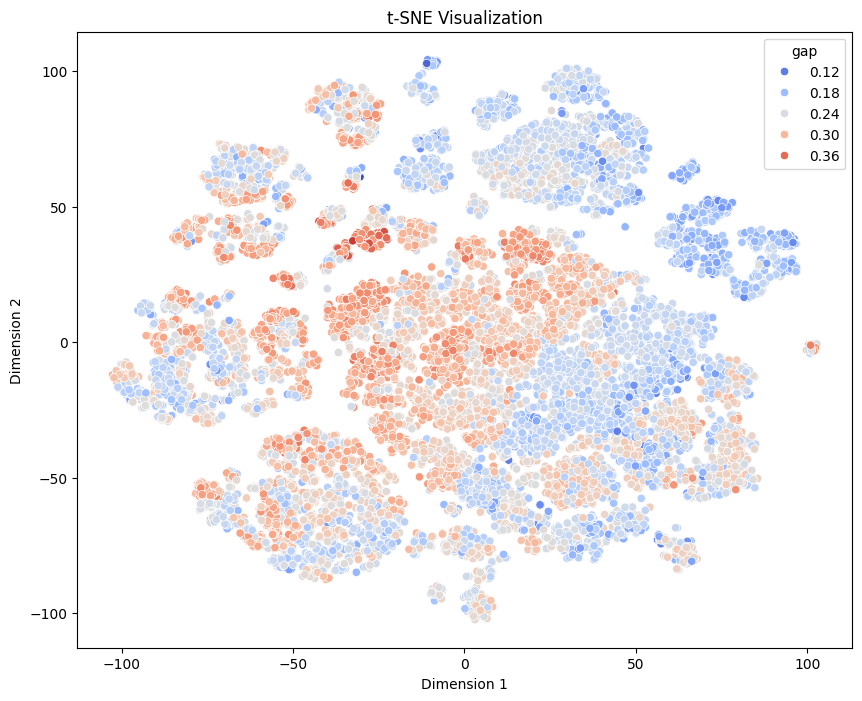

In [19]:
# Extracting descriptors and target variable
X = df.drop(['smiles', 'gap'], axis=1)
y = df['gap']

# Applying t-SNE for dimensionality reduction to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a new DataFrame with the reduced dimensions and target variable
df_tsne = pd.DataFrame(data=X_tsne, columns=['Dimension 1', 'Dimension 2'])
df_tsne['gap'] = y.values

# Visualizing the reduced dimensions using Plotly
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='gap', data=df_tsne, palette='coolwarm')
plt.title('t-SNE Visualization')
plt.show()

# Clustering

The first chosen clustering method is DBSCAN, because for this method there is no need to define the number of clusters.

For processing and visualization, components obtained by the UMAP method were used.

Unfortunately, visualization showed the clusters obtained by this model have little correlation with the `gap` value

In [12]:
from sklearn.cluster import DBSCAN

In [62]:
dbscan = DBSCAN()

# Получение меток кластеров для каждой точки данных
labels = dbscan.fit_predict(X_umap)

# Добавление меток кластеров к датафрейму
df['cluster'] = labels

In [40]:
print('Количество кластеров DBSCAN + t-SNE:', len(df['cluster'].value_counts()))

Количество кластеров DBSCAN + UMAP: 23


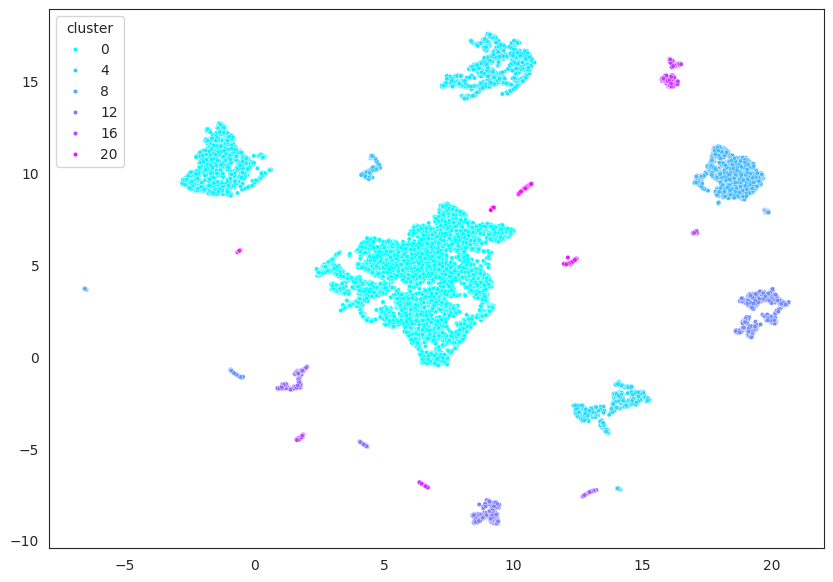

In [63]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(data=df, x=X_umap[:, 0], y=X_umap[:, 1], hue=df['cluster'], s=10, palette='cool')
plt.show()

### Clustering interpretation

Взаимосвязи `gap` и кластеров не наблюдается

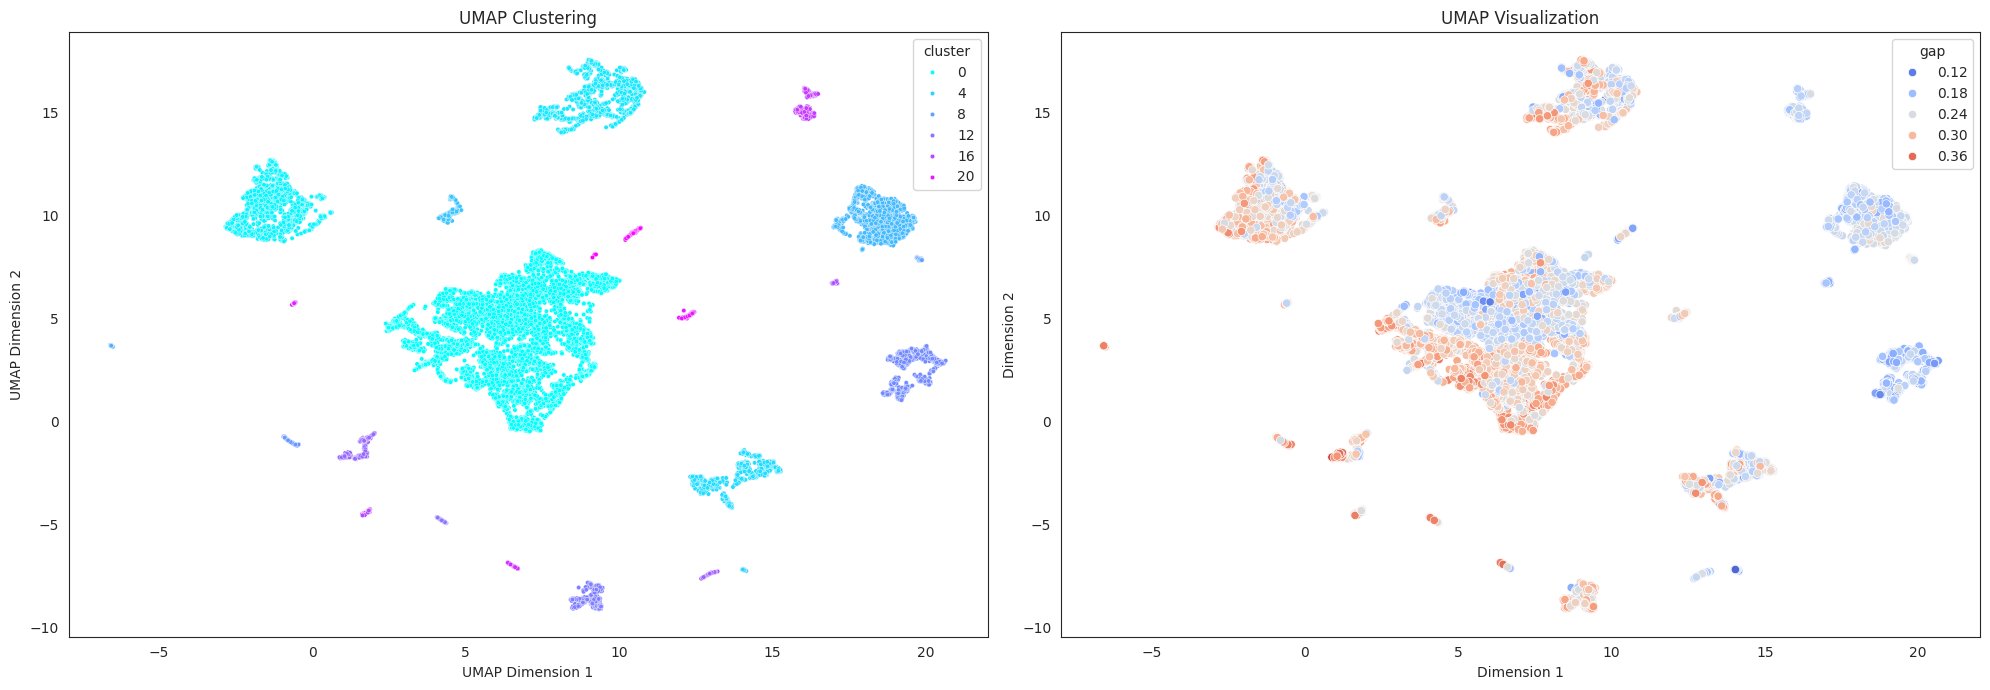

In [64]:
# Создание фигуры и осей для первого графика
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Первый график
sns.scatterplot(data=df, x=X_umap[:, 0], y=X_umap[:, 1], hue=df['cluster'], s=10, palette='cool', ax=ax[0])
ax[0].set_title('UMAP Clustering')
ax[0].set_xlabel('UMAP Dimension 1')
ax[0].set_ylabel('UMAP Dimension 2')

# Второй график
sns.scatterplot(x=cols[0], y=cols[1] if len(cols) > 1 else None, hue='gap', data=df_umap, palette='coolwarm', ax=ax[1])
ax[1].set_title('UMAP Visualization')
ax[1].set_xlabel(cols[0])
if len(cols) > 1:
    ax[1].set_ylabel(cols[1])

# Показать оба графика
plt.tight_layout()
plt.show()

# AgglomerativeClustering

We fed this model with data reduced using the t-SNE method. It show better results.

In [54]:
from sklearn.cluster import AgglomerativeClustering

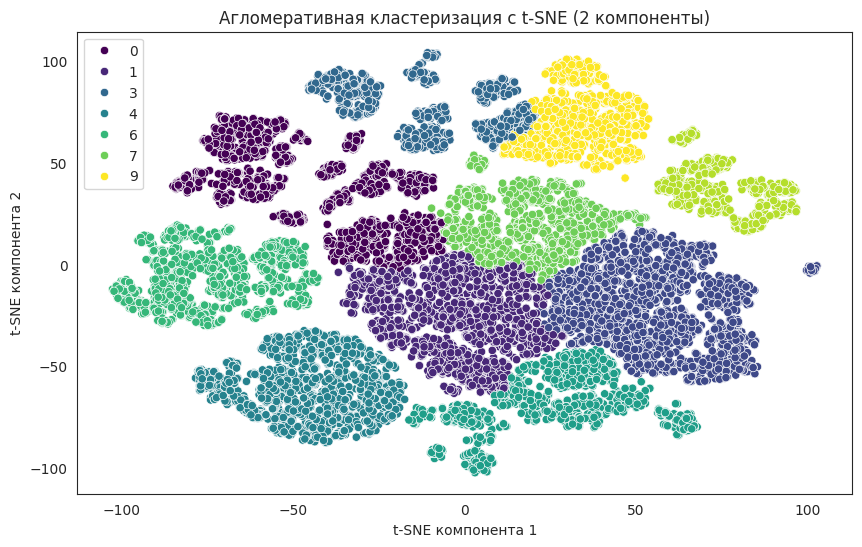

In [55]:
agglomerative = AgglomerativeClustering(n_clusters=10)
clusters = agglomerative.fit_predict(X_tsne)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=clusters, palette='viridis')
plt.title('Агломеративная кластеризация с t-SNE (2 компоненты)')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')
plt.show()

In [56]:
df['cluster'] = clusters

### Clustering interpretation

Взаимосвзяь кластеров и значений `gap` является более видимой, чем в предыдущем методе



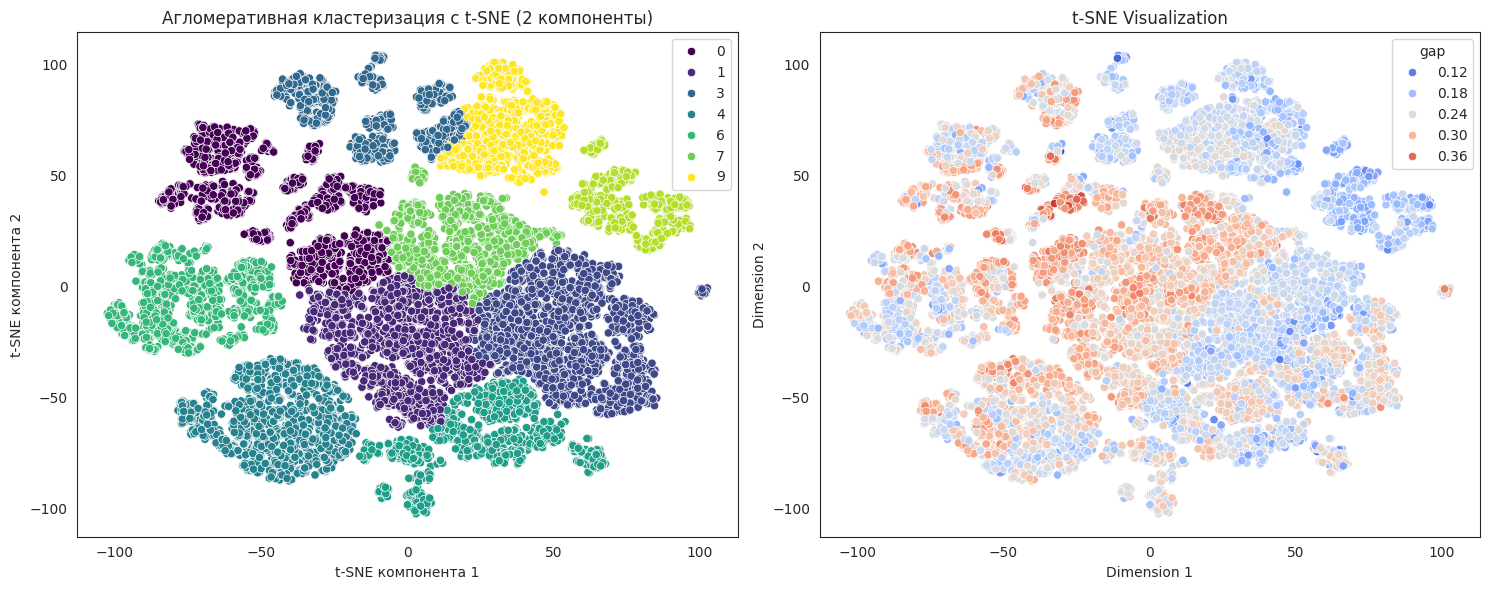

In [59]:
# Установить размер графиков
plt.figure(figsize=(15, 6))

# Первый график
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=clusters, palette='viridis')
plt.title('Агломеративная кластеризация с t-SNE (2 компоненты)')
plt.xlabel('t-SNE компонента 1')
plt.ylabel('t-SNE компонента 2')

# Второй график
plt.subplot(1, 2, 2)
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='gap', data=df_tsne, palette='coolwarm')
plt.title('t-SNE Visualization')

# Показать оба графика
plt.tight_layout()
plt.show()